# Supercontinuum and second harmonic generations

## Single Envelope

Method from [1]. I plan to validate according to their first example, quoting:

"We solved Eq. (11) by a split-step Fourier method exploiting the fourth-order Runge-Kutta scheme for the nonlinear step.
In order to show the validity of our equation, we simulated the propagation of a femtosecond pulse in a $L = 5$ mm long periodically poled lithium tantalate sample (PPLT). To model the refractive index dispersion we employed a Sellmeier model fitted from experimental data [13] and a nonlinear coefficient of $d_{33} = \chi^{(2)}_{LT}/2 = 10.6$ pm/V. In the numerical code wei nserted the exact dispersion relation $k(ω)$. We assumed a first-order quasi-phase-matching (QPM) grating, with a period $\Lambda = 17.4$ μm. We thus allowed a periodic variation of the nonlinear coefficient $\chi^{(2)} = \chi^{(2)}(z) = 2/\pi \chi^{(2)}_{LT} e^{i2π/\Lambda z} + c.c.$ We injected a $T = 60$ fs FWHM long Gaussian pulse, centered around 1400 nm, with I = 10 GW/cm2 peak intensity. The corresponding residual phase mismatch is $k = 2k(\omega_{in}) − k(2\omega_{in}) = 10 000$ m$^{−1}$, where $\omega_{in}$ is the carrier frequency of the input pulse. In the simulation we set the reference frequency $\omega_0$ to be equal to the second harmonic of the input pulse: in this way the second harmonic is stationary in the reference frame $(z,τ)$."

[1]M. Conforti, F. Baronio, and C. De Angelis, “Nonlinear envelope equation for broadband optical pulses in quadratic media,” Phys. Rev. A, vol. 81, no. 5, p. 053841, May 2010, doi: 10.1103/PhysRevA.81.053841.

We begin by the typical Python imports.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import fftpack as sp
from scipy import signal
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

## Units
We'll work in SI units. Mostly in base units.

In [2]:
from scipy.constants import pi, c, epsilon_0

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that no part of the pulse reaches the edge of the domain at any point. We will pick a reference group velocity for as the moving reference frame, so how much the pulse travels depends on the respective group velocity mismatches of all the frequency components with respect to this reference velocity.

The FFT poses the following relations between the time domain and frequency domain windows,
$$ T_\mathrm{max} = {N \Delta t} = \frac{1}{\Delta f }, \\
BW = f_s = \frac{1}{\Delta t},$$
or combining them
$$T_\mathrm{max} BW = N.$$

From the paper it seems like $T_\mathrm{max} = 2.5 \mathrm{\; ps}$. We want to chose $N$ in order to cover both harmonics with some extra padding.

In [3]:
Tmax = 2.5e-12

wl_ff = 1400e-9 #Fundamental frequency
f0_ff = c/wl_ff
f0_sh = 2*f0_ff #SHG frequency
wl_sh = c/f0_sh
BW_needed = f0_sh-f0_ff

print('Fundamental wavelength = %0.1f nm' %(wl_ff*1e9))
print('SH wavelength = %0.1f nm' %(wl_sh*1e9))
print('Fundamental frequency = %0.1f THz' %(f0_ff*1e-12))
print('SH frequency = %0.1f THz' %(f0_sh*1e-12))
print('Minimum bandwidth needed = %0.1f THz' %(BW_needed*1e-12))
print('Minimum NFFT based on Tmax and BW needed = 2**%i' %(np.ceil(np.log2(BW_needed*Tmax))))
print('\n')

NFFT = 2**11
t = np.linspace(-2.5e-12, 1e-12, NFFT)
# NFFT = 2**12
# t = np.linspace(-3.5e-12, 3.5e-12, NFFT)

Tmax = np.amax(t) - np.amin(t)
dt = t[1]-t[0]
f = fftfreq(NFFT, dt)
omega = 2*pi*f
df = f[1]-f[0]
BW = np.amax(f) - np.amin(f)

#Reference frequency
f_ref = f0_sh
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

print('Time window size = %0.3f ps' %(Tmax*1e12))
print('Sampling Rate = %0.3f fs' %(dt*1e15))
print('Frequency Resolution = %0.3f GHz' %(df*1e-9))
print('Total frequency span = %0.1f THz' %(BW*1e-12))
print('Reference wavelength = %0.1f nm' %(wl_ref*1e9))
print('Reference frequency = %0.1f THz' %(f_ref*1e-12))
print('Minimum absolute frequency = %0.1f THz' %(f_min*1e-12))
print('Maximum absolute frequency = %0.1f THz' %(f_max*1e-12))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max*1e9))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min*1e6))
print('\n')

#get the frequency indexes for fundamental and second harmonics
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f0_sh_index = np.abs(f + f_ref - f0_sh).argmin()
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for SH = %i' %(f0_sh_index))

Fundamental wavelength = 1400.0 nm
SH wavelength = 700.0 nm
Fundamental frequency = 214.1 THz
SH frequency = 428.3 THz
Minimum bandwidth needed = 214.1 THz
Minimum NFFT based on Tmax and BW needed = 2**10


Time window size = 3.500 ps
Sampling Rate = 1.710 fs
Frequency Resolution = 285.575 GHz
Total frequency span = 584.6 THz
Reference wavelength = 700.0 nm
Reference frequency = 428.3 THz
Minimum absolute frequency = 135.8 THz
Maximum absolute frequency = 720.4 THz
Minimum absolute wavelength = 416.1 nm
Maximum absolute wavelength = 2.2 um


Array index for fundamental = 1298
Array index for SH = 0


## Material properties

The higher order dispersion operator is
$$D = \beta(\Omega) - \beta_0(\Omega=0) - \beta_1(\Omega=0) \Omega$$.

Refractive index at fundamental = 2.134
Refractive index at sh = 2.180


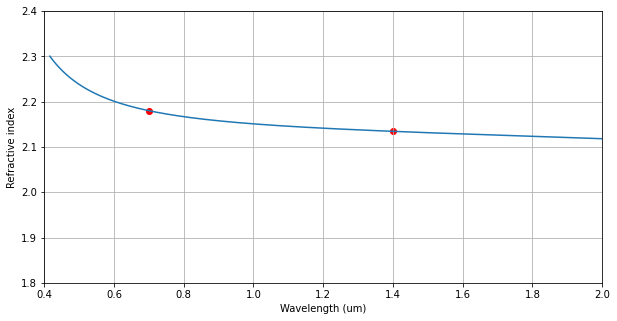

In [4]:
nLN = materials.refractive_index('LN_MgO_e', wl_abs*1e6)
nw = nLN[f0_ff_index]
n2w = nLN[f0_sh_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs*1e6), fftshift(nLN))
ax1.scatter(wl_abs[f0_ff_index]*1e6, nLN[f0_ff_index], c='r')
ax1.scatter(wl_abs[f0_sh_index]*1e6, nLN[f0_sh_index], c='r')
ax1.set_xlim([0.4,2])
ax1.set_ylim([1.8,2.4])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid('on')

print('Refractive index at fundamental = %0.3f' %(nw))
print('Refractive index at sh = %0.3f' %(n2w))

GVD at 0.700 um = 222.367 fs^2/mm
GVD at 1.400 um = 133.874 fs^2/mm
Group velocity of 1.400 um wave in moving reference plane = 0.007 mm/ps


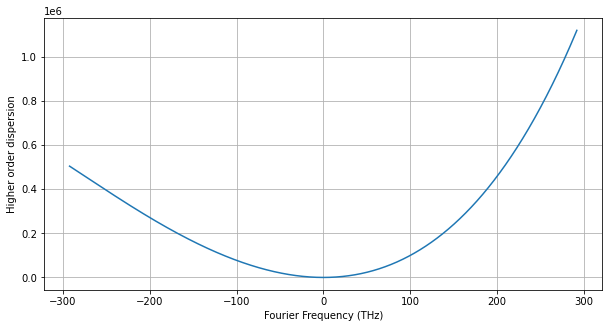

In [5]:
beta = (omega_abs)*nLN/c
beta_1 = np.gradient(beta, 2*pi*df)
beta_2 = np.gradient(beta_1, 2*pi*df)

beta_ref = beta[0]
beta_1_ref = beta_1[0]
D = beta - beta_ref - beta_1_ref*omega

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(fftshift(f)*1e-12, fftshift(D));
plt.xlabel('Fourier Frequency (THz)');
plt.grid(True)
plt.ylabel('Higher order dispersion');

#Some extra information
GVM = 1/beta_1[f0_ff_index] - 1/beta_1_ref

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ff*1e6, beta_2[f0_ff_index]*1e27))
print('Group velocity of %0.3f um wave in moving reference plane = %0.3f mm/ps' %(wl_ff*1e6, GVM*1e3*1e-12))

## Poling Period

Poling period for SHG:
$$
\Lambda = \frac{\lambda_{2\omega}}{n_{2\omega} - n_\omega}
$$

In [6]:
poling_period = (wl_sh)/(n2w-nw)
print('Poling period for SHG starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period*1e6))

delta_b = 2*beta[f0_ff_index] - beta[f0_sh_index]
print('Phase mismatch before poling = %0.1f' %(delta_b))

Poling period for SHG starting from pump at 1.40 um is 15.34 um
Phase mismatch before poling = -413486.3


## Input pulse creation

FWHM = 60.010 fs
Pulse Energy = 2254.665 J
Pulse peak power = 37577752.843 GW


(0.0, 200000000.0)

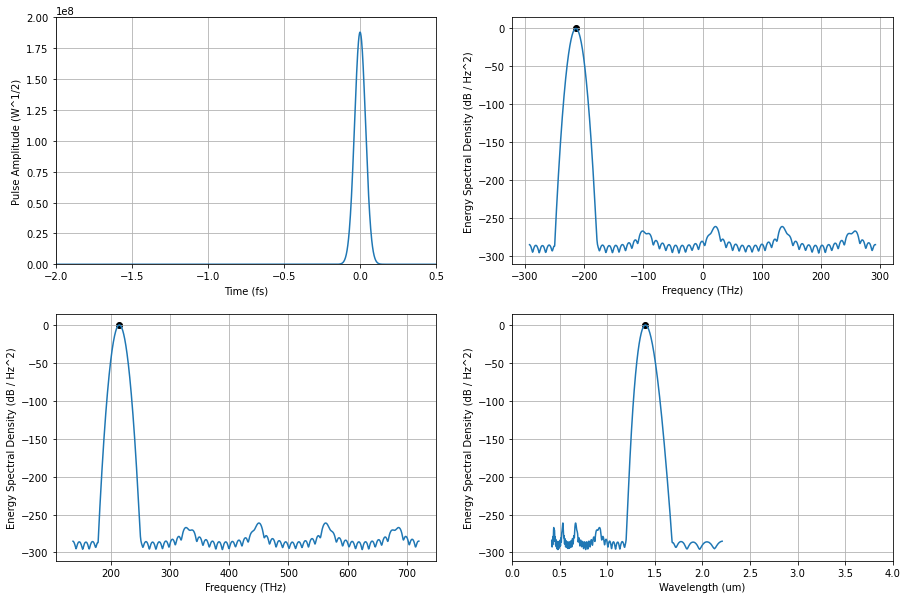

In [7]:
#Frequency offset from reference:
delta_omega = 2*pi*(f0_ff - f_ref)

#Peak value:
Intensity = 10e13 #10GW/cm^2
n = nLN[f0_ff_index]
Epeak = np.sqrt(2*Intensity/(n*c*epsilon_0))

#Pulse width:
tau = 60e-15 

#Pulse creation
pulse = Epeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*delta_omega*t)
pulse_energy = nlo.energy_td(t, pulse) #To check that everything went well

# print('Center Wavelength = %0.3f um' %(wl0*1e6))
# print('Center frequency = %0.3f THz' %(f0*1e-12))
print('FWHM = %0.3f fs' %(nlo.FWHM(t, pulse)*1e15))
print('Pulse Energy = %0.3f J' %(pulse_energy))
print('Pulse peak power = %0.3f GW' %(pulse_energy/tau*1e-9))

plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

nlo.plot_mag(t*1e12, pulse, ax=ax1)
# nlo.plot_magsq(t*1e12, pulse, ax=ax2);
nlo.plot_ESD_dB(t*1e12, pulse, ax=ax2)
nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax3)
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax4, xlim=[0,4])

ax2.scatter(f[f0_ff_index]*1e-12, 0, c='k');
ax3.scatter((f[f0_ff_index]+f_ref)*1e-12, 0, c='k');
ax4.scatter(c/(f[f0_ff_index]+f_ref)*1e6, 0, c='k');

ax1.set_xlim([-2, 0.5])
ax1.set_ylim([0,2*1e8])

#Add filter ???
# sos = signal.butter(15, [0.45, 0.55], 'bandpass', output='sos')
# w, hfilter = signal.sosfreqz(sos, worN=NFFT)

# ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a, f_ref*1e-12)
# ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax1)
# ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(hfilter)));
# ax1.set_ylim([-100,10])

## Nonlinear  Stuff

In [8]:
def poling_sinusoidal(z, pp):
    return (2/pi)*np.cos(z*2*pi/pp)

def chi2(z):
    poling = poling_sinusoidal(z, pp)
    return 2*d33*poling

def chi(z):
#     return chi2(z)*omega_ref/(4*nLN[0]*c)
    return chi2(z)*(omega+omega_ref)/(4*nLN*c)

def nonlinear_operator(z, A):
# Original equation
#     phi = omega_ref*t - (beta_ref - beta_1_ref*omega_ref)*z
#     f1 = A*A*np.exp(1j*phi) + 2*A*np.conj(A)*np.exp(-1j*phi)
#     f1_deriv = np.gradient(f1, dt)
#     f = -1j*chi(z)*f1 - 1*(chi(z)/omega_ref)*f1_deriv
    
#From Chris's thesis
    phi = omega_ref*t - (beta_ref - beta_1_ref*omega_ref)*z
    f1 = A*A*np.exp(1j*phi) + 2*A*np.conj(A)*np.exp(-1j*phi)
    f = -1j*ifft(chi(z)*fft(f1))
    return f

In [9]:
def propagate(A, D):
    
    A_evol = 1j*np.zeros([t.size, Nsteps+1])
    A_evol[:,0] = A #Initial value
    
    Da = np.exp(-1j*D*h)
    z = 0
    
    for kz in range(Nsteps):
        #Linear step
        A = ifft(Da*fft(A))

        #Nonlinear step
        #Runge-Kutta 4th order
        k1 = nonlinear_operator(z    , A       )
        k2 = nonlinear_operator(z+h/2, A+h*k1/2)
        k3 = nonlinear_operator(z+h/2, A+h*k2/2)
        k4 = nonlinear_operator(z+h  , A+h*k3  )

        z = z + h
        A = A + (h/6)*(k1+2*k2+2*k3+k4) 
        
        A_evol[:, kz+1] = A
    
    return A, A_evol

In [10]:
#Crystal parameters
L = 5e-3
h = 1e-3/500
Nsteps = int(L/h)+1
d33 = 10.6e-12
pp = poling_period

print('Crystal length = %0.2f mm' %(L*1e3))
print('Step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(Nsteps))
print('Nonlinear coefficient, d33 = %0.2f pm/V' %(d33*1e12))
print('Using periodic poling with period = %0.3f um' %(pp*1e6))

Crystal length = 5.00 mm
Step size = 2.00 um
Number of steps = 2501
Nonlinear coefficient, d33 = 10.60 pm/V
Using periodic poling with period = 15.340 um


## Single pass

In [11]:
[a, a_evol] = propagate(pulse, D)

2254.6651705543054
2230.9072349800326


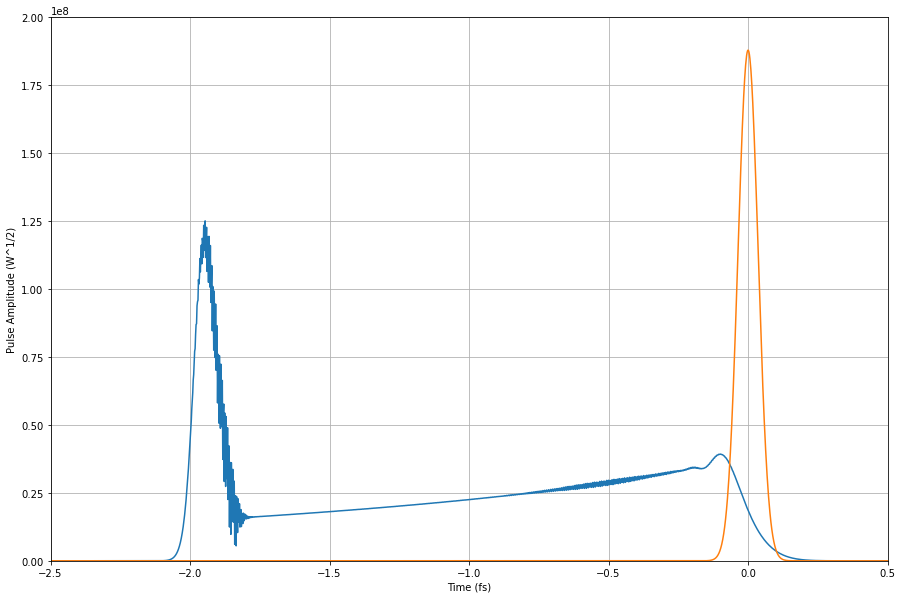

In [20]:
ax1 = nlo.plot_mag(t*1e12, a)
ax1 = nlo.plot_mag(t*1e12, pulse, ax=ax1)
ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0,2e8)

print(nlo.energy_td(t,pulse))
print(nlo.energy_td(t,a))

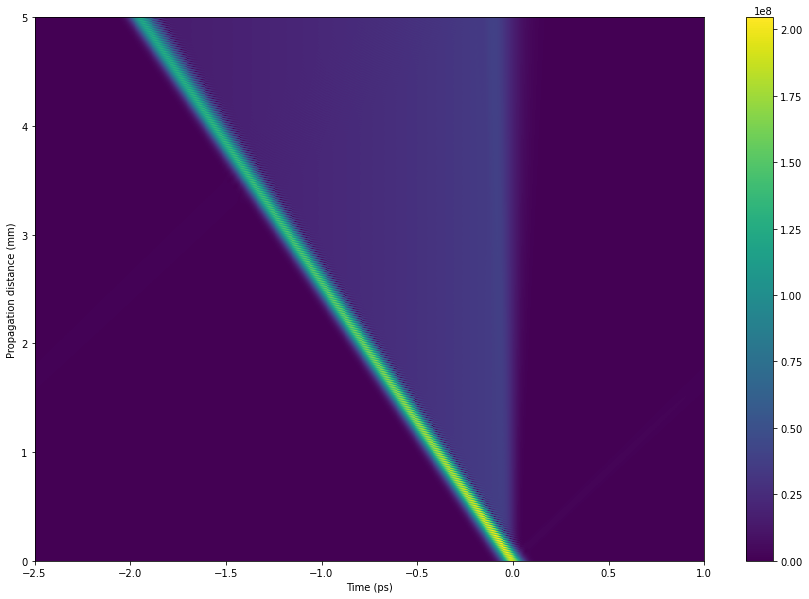

In [13]:
X,Y = np.meshgrid(t*1e12, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))))
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
ax.set_ylim([0,5])
plt.colorbar(im, ax=ax)

## Filter and plot harmonics

C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(-50.0, 10.0)

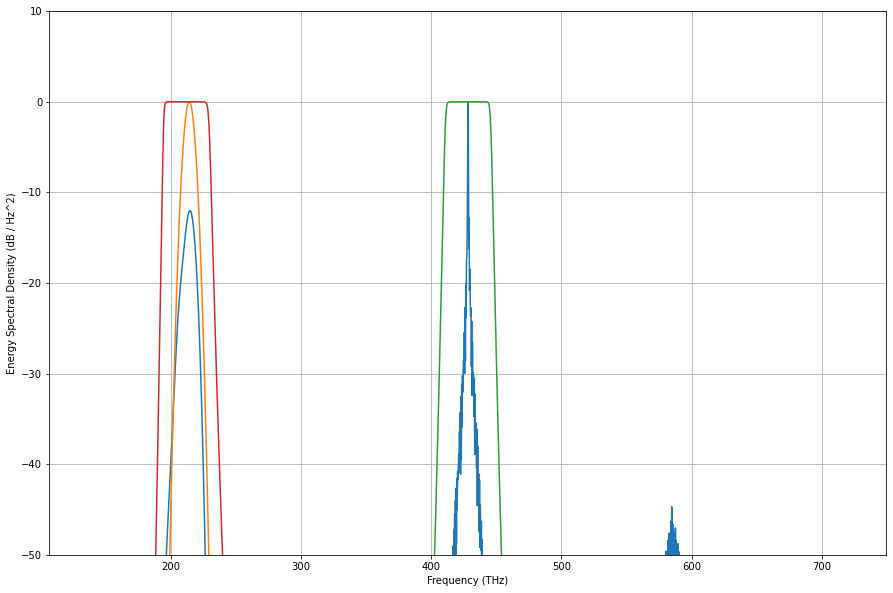

In [14]:
sos = signal.butter(15, [0.47, 0.53], 'bandpass', output='sos')
_, h_sh = signal.sosfreqz(sos, worN=NFFT)

sos = signal.butter(15, [0.1, 0.16], 'bandpass', output='sos')
_, h_ff = signal.sosfreqz(sos, worN=NFFT)

ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a, f_ref*1e-12)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax1)
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_sh)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_ff)));
ax1.set_ylim([-50,10])

C:\Users\luish\Documents\Github\Photonics_python_Luis\Modules\nlo.py:38: RuntimeWarning: divide by zero encountered in log10
  Xesd_dB = 10*log10(Xesd_rel)
C:\Users\luish\Documents\Github\Photonics_python_Luis\Modules\nlo.py:38: RuntimeWarning: divide by zero encountered in log10
  Xesd_dB = 10*log10(Xesd_rel)


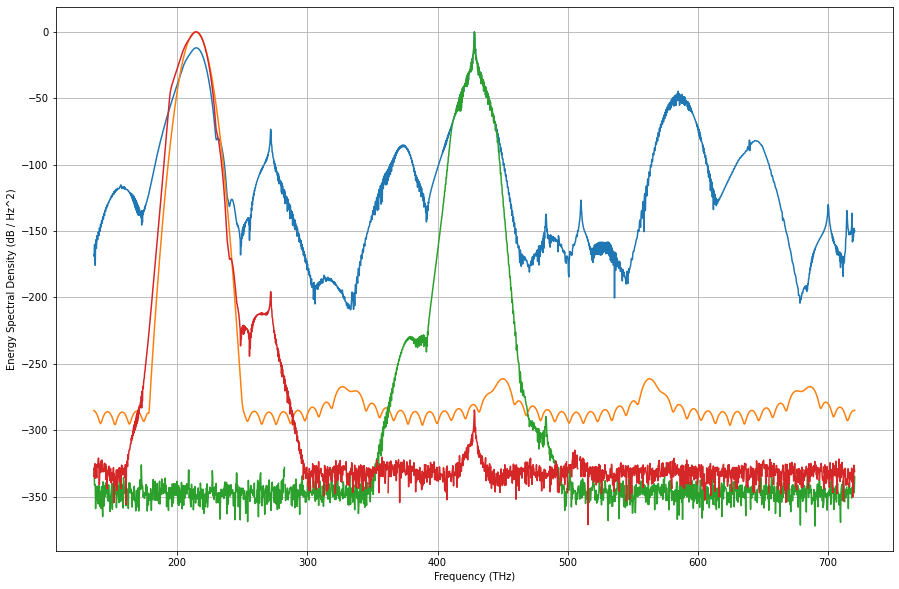

In [15]:
a_sh = ifft(fft(a)*fftshift(h_sh))
a_ff = ifft(fft(a)*fftshift(h_ff))
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a, f_ref*1e-12)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax1)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a_sh, f_ref*1e-12, ax=ax1)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e12, a_ff, f_ref*1e-12, ax=ax1)
# ax1.set_ylim([-50,10])

(0.0, 200000000.0)

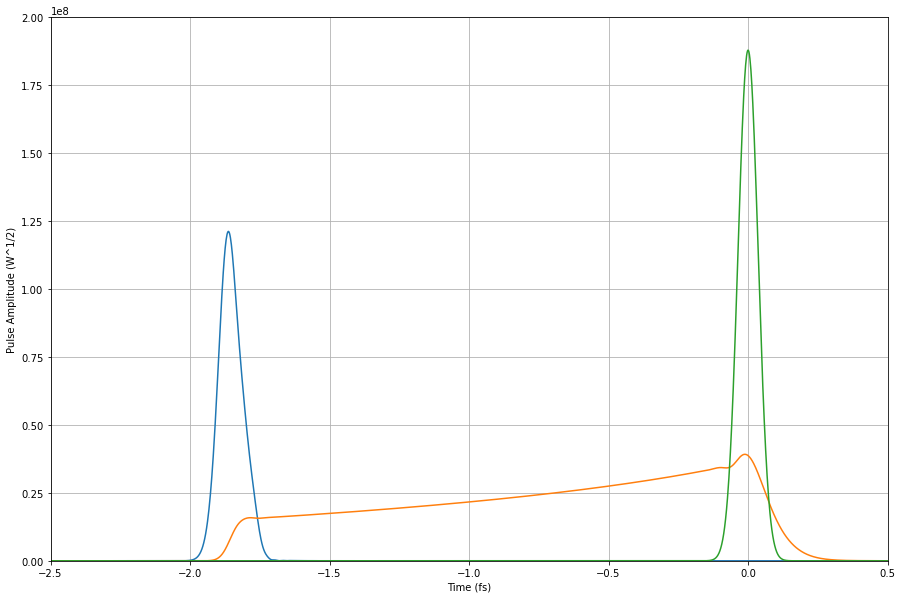

In [16]:
ax1 = nlo.plot_mag(t*1e12, a_ff)
ax1 = nlo.plot_mag(t*1e12, a_sh, ax=ax1)
ax1 = nlo.plot_mag(t*1e12, pulse, ax=ax1)
ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0, 2e8)

## Spectrum

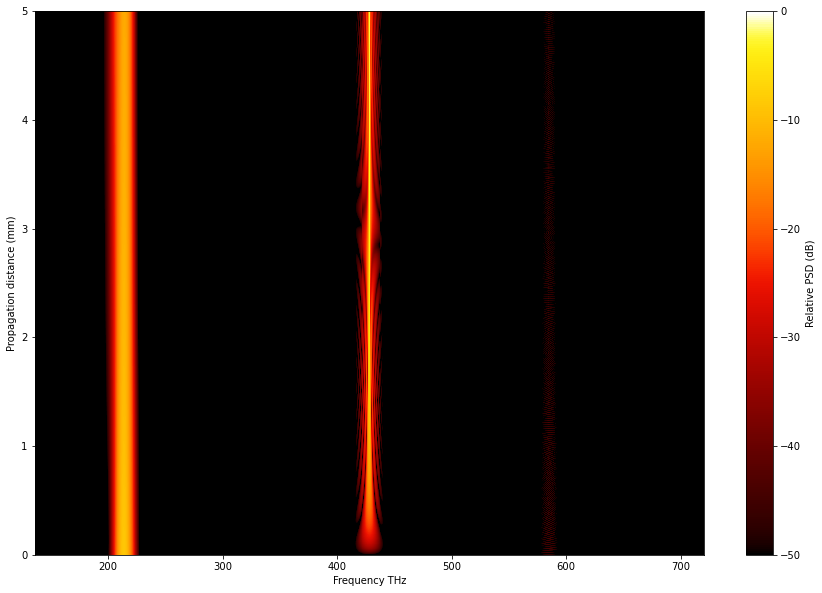

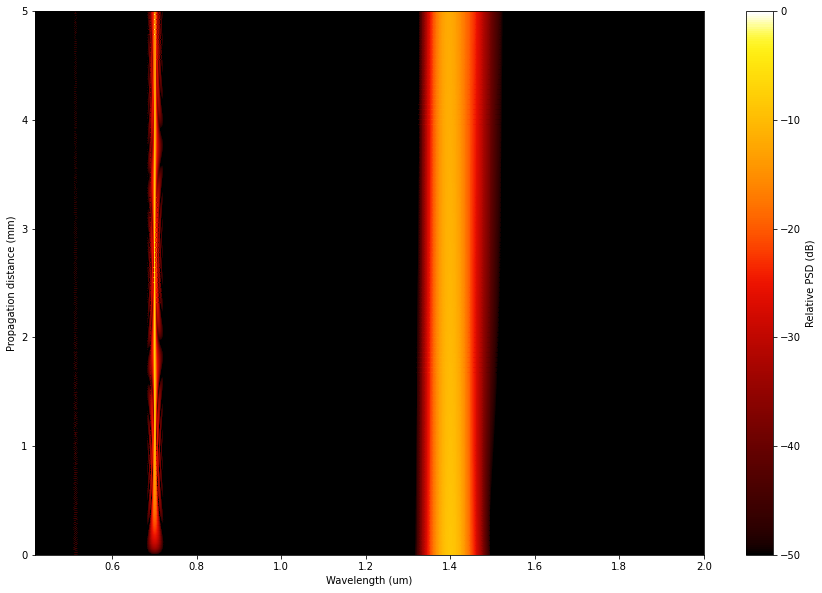

In [17]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t*1e15, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-50, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency THz')
plt.ylabel('Propagation distance (mm)');

wl_max = 2
wl_array = c/(fftshift(f)+f_ref)*1e6
wl_max_idx = np.abs(wl_array - wl_max).argmin()
wl_array = wl_array[wl_max_idx:]
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol[wl_max_idx:, :])), cmap = cc.cm["fire"], vmin=-50, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');